## First model

In [3]:
import pandas as pd

from torch.utils.data import Dataset
from transformers import GPT2Tokenizer

from transformers import GPT2LMHeadModel
from transformers import get_linear_schedule_with_warmup

from torch.optim import AdamW

from transformers import get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
import os
from pathlib import Path

Load our data

In [9]:
data_path = Path(os.getcwd()).parent / 'data'

df = pd.read_csv(f'{data_path}/lyrics_filtered_768tokens.csv')


print(f"Loaded {len(df):,} songs")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst row preview:")
print(df.iloc[0])

Loaded 39,415 songs

Columns: ['genre', 'lyrics', 'token_count', 'formatted_text']

First row preview:
genre                                                           Pop
lyrics            I feel so unsure\nAs I take your hand and lead...
token_count                                                     400
formatted_text    Genre: Pop\n\nI feel so unsure\nAs I take your...
Name: 0, dtype: object


In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# ['gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl']
model_name = 'distilgpt2'
model_save_path = Path(os.getcwd()).parent / 'models'

In [11]:
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

print(f"\nTokenizer loaded:")
print(f"Vocab size: {len(tokenizer):,}")
print(f"EOS token: '{tokenizer.eos_token}' (ID: {tokenizer.eos_token_id})")
print(f"PAD token: '{tokenizer.pad_token}' (ID: {tokenizer.pad_token_id})")


Tokenizer loaded:
Vocab size: 50,257
EOS token: '<|endoftext|>' (ID: 50256)
PAD token: '<|endoftext|>' (ID: 50256)


### Custom dataset

In [7]:
class LyricsDataset(Dataset):
    
    def __init__(self, formatted_texts, tokenizer, max_length=768):

        self.input_ids = []
        self.attn_masks = []
        
        print(f"Pre-tokenizing {len(formatted_texts)} songs...")
        for text in tqdm(formatted_texts):
            encodings = tokenizer.encode_plus(
                text,
                truncation=True,
                padding='max_length',
                max_length=max_length,
                return_tensors='pt'
            )
            self.input_ids.append(encodings['input_ids'].squeeze(0))
            self.attn_masks.append(encodings['attention_mask'].squeeze(0))
        
        print("Tokenization complete")
    
    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attn_masks[idx],
            'labels': self.input_ids[idx]
        }


## Initialise the data

In [12]:

train_df, val_df = train_test_split(
    df, 
    test_size=0.2, 
    stratify=df['genre'],
    random_state=6
)

train_dataset = LyricsDataset(train_df['formatted_text'].tolist(), tokenizer, 768)
val_dataset = LyricsDataset(val_df['formatted_text'].tolist(), tokenizer, 768)

Pre-tokenizing 31532 songs...


  0%|          | 0/31532 [00:00<?, ?it/s]

Tokenization complete
Pre-tokenizing 7883 songs...


  0%|          | 0/7883 [00:00<?, ?it/s]

Tokenization complete


In [14]:
print(f"Dataset size: {len(train_dataset)}")
sample = train_dataset[0]
print(f"Sample shapes:")
print(f"  input_ids: {sample['input_ids'].shape}")
print(f"  attention_mask: {sample['attention_mask'].shape}")

Dataset size: 31532
Sample shapes:
  input_ids: torch.Size([768])
  attention_mask: torch.Size([768])


Create data loaders

In [ ]:
BATCH_SIZE = 2
MAX_LENGTH = 512

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False, 
    num_workers=0,
    pin_memory=False
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

Train batches: 15766
Val batches: 1971
Test batches: 1971


### Train LOOP

In [ ]:

def train_loop(model, optimizer, scheduler, train_loader, device, epoch, num_epochs):
    model.train()
    epoch_train_loss = 0
    print(f"Starting training epoch {epoch+1}/{num_epochs} with {len(train_loader)} batches")
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} (Training)")
    for batch in progress_bar:
            try:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)

                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=input_ids
                )
                loss = outputs.loss
                epoch_train_loss += loss.item()

                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                scheduler.step()
                progress_bar.set_postfix({'train_loss': loss.item()})
                progress_bar.refresh()
            
            except RuntimeError as e:
                print(f"Error in training batch: {e}")
                raise
    avg_train_loss = epoch_train_loss / len(train_loader)
    return avg_train_loss

def validation_loop(model, val_loader, device, epoch, num_epochs):
        model.eval()
        epoch_val_loss = 0
        progress_bar =  tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} (Validation)")
        with torch.no_grad():
            for batch in progress_bar:
                try:
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)

                    outputs = model(
                        input_ids=input_ids,
                        attention_mask=attention_mask,
                        labels=input_ids
                    )
                    epoch_val_loss += outputs.loss.item()
                
                except RuntimeError as e:
                    print(f"Error in validation batch: {e}")
                    raise

        avg_val_loss = epoch_val_loss / len(val_loader)
        return avg_val_loss

def train_gpt2_model(
    model,
    train_loader,
    val_loader,
    device,
    optimizer,
    scheduler,
    num_epochs=3,
    patience=2,
    model_name="last_training"
    ):
    os.makedirs("./models", exist_ok=True)
    print('Using:', device)
    model = model.to(device)
    model.train()
    
    best_val_loss = float('inf')
    patience_counter = 0
    history = {
        'train_loss': [],
        'val_loss': [],
    }

    # Training loop
    for epoch in range(num_epochs):

        epoch_train_loss = train_loop(model, optimizer, scheduler, train_loader, device, epoch, num_epochs)
        # Train
        avg_train_loss = epoch_train_loss / len(train_loader)
        print(f"Epoch {epoch + 1}/{num_epochs} - Avg Training Loss: {avg_train_loss:.4f}")
        history['train_loss'].append(avg_train_loss)
        # Val
        avg_val_loss = validation_loop(model, val_loader, device, epoch, num_epochs)
        history['val_loss'].append(avg_val_loss)
        print(f"Epoch {epoch + 1}/{num_epochs}: Avg Validation Loss: {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss - 0.01:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f"./models/{model_name}.pt")
            print(f'Saved best model checkpoint: epoch {epoch + 1}')
        else:
            patience_counter += 1
            print(f"Patience counter: {patience_counter}/{patience}")
            if patience_counter >= patience:
                print(f"Early stopping triggered after epoch {epoch + 1}")
                break
    print("Done!")            
    return model, history
    

### Test with small dataset

In [21]:
# get 10 procent of the data
small_df, _ = train_test_split(
    df,
    train_size=0.1,
    stratify=df['genre'],
    random_state=6
)
print(f"Genre distribution:\n{small_df['genre'].value_counts()}")
BATCH_SIZE = 4
MAX_LENGTH = 512

small_train_df, small_val_df = train_test_split(
    small_df, 
    test_size=0.2, 
    stratify=small_df['genre'],
    random_state=6
)
small_train_dataset = LyricsDataset(small_train_df['formatted_text'].tolist(), tokenizer, MAX_LENGTH)
small_val_dataset = LyricsDataset(small_val_df['formatted_text'].tolist(), tokenizer, MAX_LENGTH)

small_train_loader = DataLoader(
    small_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=False
)

small_val_loader = DataLoader(
    small_val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)
LEARNING_RATE = 3e-5
NUM_EPOCHS = 5
WARMUP_STEPS = 500
WARMUP_RATIO = 0.1
WEIGHT_DECAY = 0.01

small_model = GPT2LMHeadModel.from_pretrained(model_name)
model = small_model.to(device)

optimizer = AdamW(small_model.parameters(), lr=LEARNING_RATE, weight_decay= WEIGHT_DECAY)

total_steps = len(small_train_loader) * NUM_EPOCHS
warmup_steps = int(total_steps * WARMUP_RATIO)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=WARMUP_STEPS,
    num_training_steps=total_steps
)
print(f"\n{'='*60}")
print("TRAINING CONFIGURATION")
print(f"{'='*60}")
print(f"Model: {model_name}")
print(f"Device: {device}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Max length: {MAX_LENGTH}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Epochs: {NUM_EPOCHS}")
print(f"Total steps: {total_steps}")
print(f"Warmup steps: {warmup_steps}")
print(f"{'='*60}")


Genre distribution:
genre
Heavy Metal    1337
Pop            1313
Indie          1291
Name: count, dtype: int64
Pre-tokenizing 3152 songs...


  0%|          | 0/3152 [00:00<?, ?it/s]

Tokenization complete
Pre-tokenizing 789 songs...


  0%|          | 0/789 [00:00<?, ?it/s]

Tokenization complete

TRAINING CONFIGURATION
Model: distilgpt2
Device: cuda
Batch size: 4
Max length: 512
Learning rate: 3e-05
Epochs: 5
Total steps: 3940
Warmup steps: 394


In [22]:
small_model, history = train_gpt2_model(small_model, small_train_loader, small_val_loader, device, optimizer, scheduler, num_epochs=NUM_EPOCHS)

Using: cuda
Starting training epoch 1/5 with 788 batches


Epoch 1/5 (Training):   0%|          | 0/788 [00:00<?, ?it/s]

Epoch 1/5 - Avg Training Loss: 0.0025


Epoch 1/5 (Validation):   0%|          | 0/198 [00:00<?, ?it/s]

Epoch 1/5: Avg Validation Loss: 1.4865
Saved best model checkpoint: epoch 1
Starting training epoch 2/5 with 788 batches


Epoch 2/5 (Training):   0%|          | 0/788 [00:00<?, ?it/s]

Epoch 2/5 - Avg Training Loss: 0.0020


Epoch 2/5 (Validation):   0%|          | 0/198 [00:00<?, ?it/s]

Epoch 2/5: Avg Validation Loss: 1.4656
Saved best model checkpoint: epoch 2
Starting training epoch 3/5 with 788 batches


Epoch 3/5 (Training):   0%|          | 0/788 [00:00<?, ?it/s]

Epoch 3/5 - Avg Training Loss: 0.0019


Epoch 3/5 (Validation):   0%|          | 0/198 [00:00<?, ?it/s]

Epoch 3/5: Avg Validation Loss: 1.4601
Patience counter: 1/2
Starting training epoch 4/5 with 788 batches


Epoch 4/5 (Training):   0%|          | 0/788 [00:00<?, ?it/s]

Epoch 4/5 - Avg Training Loss: 0.0019


Epoch 4/5 (Validation):   0%|          | 0/198 [00:00<?, ?it/s]

Epoch 4/5: Avg Validation Loss: 1.4603
Patience counter: 2/2
Early stopping triggered after epoch 4


In [23]:
import matplotlib.pyplot as plt
import numpy as np
def plot_training_history(history, save_path=None):
    """Plot training curves"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    epochs = range(1, len(history['train_loss']) + 1)

    axes[0].plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
    axes[0].plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Training and Validation Loss', fontsize=14)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    train_perplexity = [torch.exp(torch.tensor(loss)).item() for loss in history['train_loss']]
    val_perplexity = [torch.exp(torch.tensor(loss)).item() for loss in history['val_loss']]
    
    axes[1].plot(epochs, train_perplexity, 'b-', label='Train Perplexity', linewidth=2)
    axes[1].plot(epochs, val_perplexity, 'r-', label='Val Perplexity', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Perplexity', fontsize=12)
    axes[1].set_title('Training and Validation Perplexity', fontsize=14)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

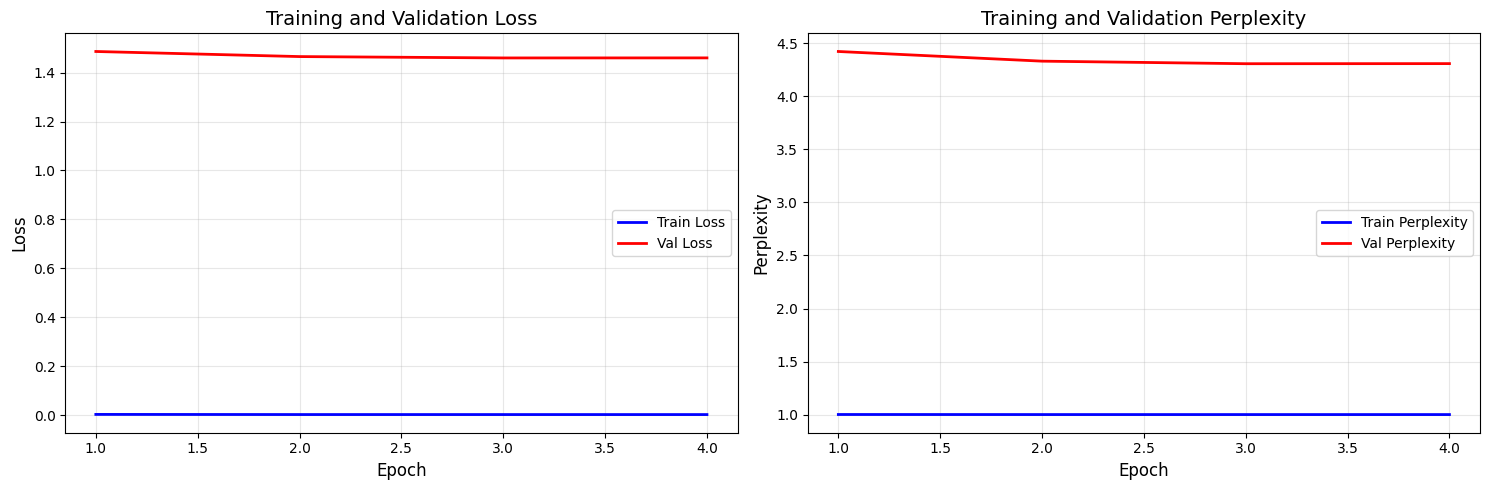

In [24]:
plot_training_history(history)

 ### Big TF

In [ ]:
from transformers import get_linear_schedule_with_warmup

LEARNING_RATE = 3e-5
NUM_EPOCHS = 3
WARMUP_RATIO = 0.05

model = GPT2LMHeadModel.from_pretrained(model_name)
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

total_steps = len(train_loader) * NUM_EPOCHS
warmup_steps = int(total_steps * WARMUP_RATIO)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

model2, train_losses_b, val_losses_b = train_gpt2_model(model, train_loader, val_loader, device, optimizer, scheduler, num_epochs=NUM_EPOCHS, model_name='gpt2_all_data_model')

Using: cuda
Starting training epoch 1/3 with 15766 batches


Epoch 1/3 (Training):   0%|          | 0/15766 [00:00<?, ?it/s]

Epoch 1/2 (Training):   0%|          | 0/31532 [28:22<?, ?it/s, train_loss=0.794]


KeyboardInterrupt: 

In [ ]:
plot_training_curves(train_losses_b, val_losses_b)